# 1. 项目背景

Kaggle自行车租赁预测比赛,这是一个连续值预测的问题,也就是我们说的机器学习中的回归问题,咱们一起来看看这个问题。

这是一个城市自行车租赁系统,提供的数据为2年内华盛顿按小时记录的自行车租赁数据,其中训练集由每个月
的前19天组成,测试集由20号之后的时间组成（需要我们自己去预测）。

Kaggle自行车租赁预测比赛:https://www.kaggle.com/c/bike-sharing-demand
        

# 2.实现步骤

- 1.加载数据
- 2.数据分析
- 3.特征数据提取
- 4.准备训练集数据,测试集数据
- 5.模型选择,先用自己合适算法跑一个baseline的model出来,再进行后续的分析步骤,一步步提高。
- 6.参数调优,用Grid Search找最好的参数
- 7.用模型预测打分

## 2.1 加载数据

In [1]:
import pandas as pd
import numpy as np

In [2]:
#load data, review the fild and data type
import pandas as pd

df_train = pd.read_csv("train.csv") 
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [4]:
df_train.shape

(10886, 12)

看看有没有缺省的字段，好吧，其实哪个字段的数据都不缺！

In [5]:
df_train.count()

datetime      10886
season        10886
holiday       10886
workingday    10886
weather       10886
temp          10886
atemp         10886
humidity      10886
windspeed     10886
casual        10886
registered    10886
count         10886
dtype: int64

训练集有10886个样本，12个变量，没有缺省值。

**认识数据**

项目数据描述如下： 

    (1) datetime：日期，以年-月-日 小时的形式给出。 
    (2) season：季节。1 为春季, 2为夏季,3 为秋季,4 为冬季。
    (3) hodliday：是否为假期。1代表是，0代表不是。 
    (4) workingday：是否为工作日，1代表是，0代表不是。 
    (5) weather:天气： 
        1: 天气晴朗或者少云/部分有云。 
        2: 有雾和云/风等。 
        3: 小雪/小雨，闪电及多云。 
        4: 大雨/冰雹/闪电和大雾/大雪。   
    (6) temp - 摄氏温度。 
    (7) atemp - 体感温度。 
    (8) humidity - 湿度。 
    (9) windspeed - 风速。 
    (10) casual - 非注册用户租界数量
    (11) registered - 注册用户租界数量。 
    (12) count - 总租车数，即casual+registered数目。 
    其中10~12不属于特征，12为我们需要预测的值。

数据类型：

    分类型数据：season，holiday，workingday，weather
    数值型数据：temp，atemp，humidity，windspeed，casual，registered，count
    时间序列数据：datetime

观察训练数据的描述统计信息

In [6]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## 2.2 数据分析

经过上述分析，发现datetime数值包含的信息很多，我们将月、日、和 小时单独拎出来，放到3列中，然后删除与模型学习无关的变量。

In [7]:
#来处理时间,因为它包含的信息总是非常多的,毕竟变化都是随着时间发生的嘛
df_train.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16


In [8]:
dix = pd.DatetimeIndex(df_train.datetime)

In [9]:
dix

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2012-12-19 14:00:00', '2012-12-19 15:00:00',
               '2012-12-19 16:00:00', '2012-12-19 17:00:00',
               '2012-12-19 18:00:00', '2012-12-19 19:00:00',
               '2012-12-19 20:00:00', '2012-12-19 21:00:00',
               '2012-12-19 22:00:00', '2012-12-19 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=10886, freq=None)

In [10]:
dix.hour[9]

9

In [11]:

df_train['hour']=pd.DatetimeIndex(df_train.datetime).hour
df_train['day']=pd.DatetimeIndex(df_train.datetime).dayofweek
df_train['month']=pd.DatetimeIndex(df_train.datetime).month

#other method  
# df_train['dt']=pd.to_datetime(df_train['datetime'])
# df_train['day_of_week']=df_train['dt'].apply(lambda x:x.dayofweek)
# df_train['day_of_month']=df_train['dt'].apply(lambda x:x.day)

df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5,1


保存原数据集并抛掉不要的字段

In [12]:
df_train_origin = df_train 
df_train = df_train.drop(['datetime','casual','registered'], axis = 1)

In [13]:
#数据集一定要注意，不要直接看所有，容易内存爆掉
df_train['count'].values[:10]

array([16, 40, 32, 13,  1,  1,  2,  3,  8, 14], dtype=int64)

In [14]:
names = list(df_train.columns)

In [15]:
df_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'hour', 'day', 'month'],
      dtype='object')

In [16]:
#data = df_train[['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
#       'humidity', 'windspeed', 'hour', 'day', 'month', 'count']]

In [17]:
#data.head(1)

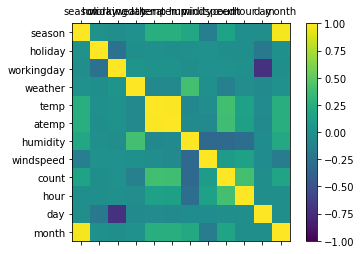

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

correlations = df_train.corr()  #计算变量之间的相关系数矩阵
# plot correlation matrix
fig = plt.figure() #调用figure创建一个绘图对象  50,30),dpi=50
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)  #绘制热力图，从-1到1
fig.colorbar(cax)  #将matshow生成热力图设置为颜色渐变条
ticks = np.arange(0,12,1) #生成0-12，步长为1
ax.set_xticks(ticks)  #生成刻度
ax.set_yticks(ticks)
ax.set_xticklabels(names) #生成x轴标签
ax.set_yticklabels(names)
plt.show()

In [19]:
df_train.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439,-0.006546,-0.010553,0.971524
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393,-0.000354,-0.191832,0.001731
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594,0.002780,-0.704267,-0.003394
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655,-0.022740,-0.047692,0.012144
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454,0.145430,-0.038466,0.257589
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784,0.140343,-0.040235,0.264173
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371,-0.278011,-0.026507,0.204537
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369,0.146631,-0.024804,-0.150192
count,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000,0.400601,-0.002283,0.166862
hour,-0.006546,-0.000354,0.002780,-0.022740,0.145430,0.140343,-0.278011,0.146631,0.400601,1.000000,-0.002925,-0.006818


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020C965B8DA0>,
      dtype=object)

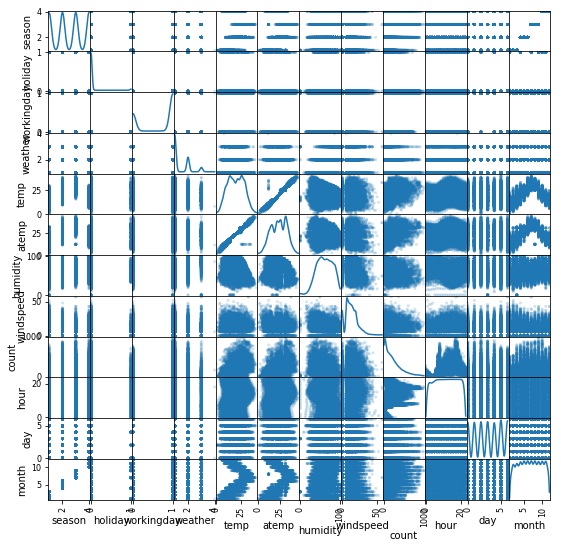

In [20]:
pd.plotting.scatter_matrix(df_train, alpha=0.2, figsize=(9,9), diagonal='kde')

## 2.3 特征数据提取

将数据集分为两部分：

- 1. df_train_target：目标，也就是count字段。 
- 2. df_train_data：用于产出特征的数据

In [117]:
df_train_target = df_train['count'].values
#df_train_data = df_train.drop(['count'],axis = 1).values
#df_train_data = df_train(['season'],['holiday'],['workingday'],['weather'],['hour']).values
df_train_data = df_train.drop(['count','atemp','humidity','month'],axis = 1).values

In [118]:
print('df_train_data shape is ', df_train_data.shape)
print('df_train_target shape is ', df_train_target.shape)

df_train_data shape is  (10886, 8)
df_train_target shape is  (10886,)


也可以用另外的方式提取字段

In [119]:

# df = df_train.drop(['datetime','casual','registered'],axis=1,inplace=True)
df_train_other = df_train[['season','holiday','workingday','weather','temp','atemp',
               'humidity','windspeed','count','month','day','hour']]
#df=df_train['datetime']
df_train_other.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,40,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,32,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,13,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,1,1,5,4


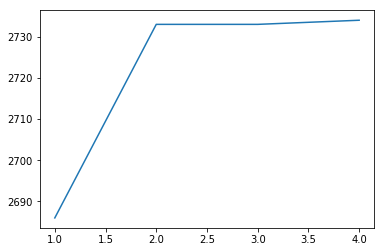

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline
df_train.season.value_counts().sort_index().plot()

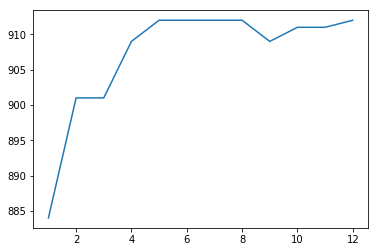

In [121]:
df_train.month.value_counts().sort_index().plot()

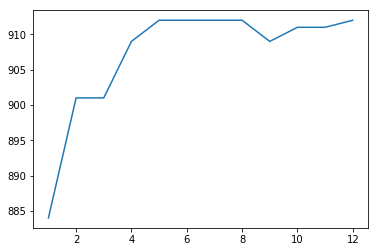

In [122]:
df_train.month.value_counts().sort_index().plot()

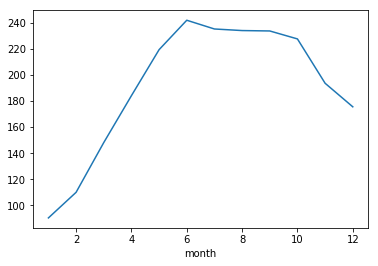

In [123]:
df_train.groupby("month")['count'].mean().plot()

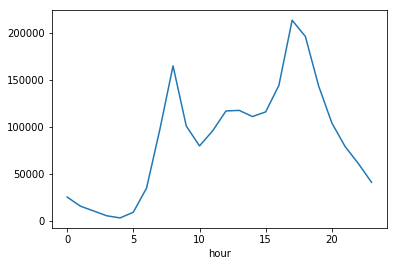

In [124]:
df_train.groupby("hour").sum()['count'].sort_index().plot()

In [125]:
df_train.day.unique()

array([5, 6, 0, 1, 2, 3, 4], dtype=int64)

In [126]:
df_train.hour.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [127]:
hourday = df_train.groupby(['hour','day'])['count'].mean()

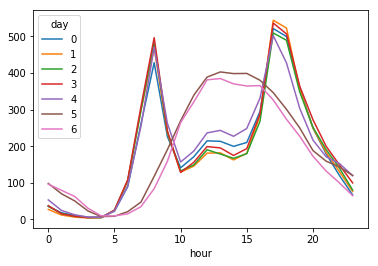

In [128]:
hourday.unstack().plot()#行变列

## 2.4 准备训练集数据,测试集数据:

上文中的特征数据即为训练集数据

- 1. df_train_target：目标,也就是count字段。
- 2. df_train_data：用于产出特征的数据

## 2.5 模型选择

应用机器学习算法的过程，多半是在调参，各种不同的参数会带来不同的结果（比如正则化系数，比如决策树类的算法的树深和棵树，比如距离判定准则等等等等）

咱们依旧会使用交叉验证的方式（交叉验证集约占全部数据的20%）来看看模型的效果,
我们尝试 支持向量回归/Suport Vector Regression, 岭回归/Ridge Regression 和
随机森林回归/Random Forest Regressor。每个模型会跑3趟看平均的结果。

In [129]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import model_selection  
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score

import warnings
warnings.filterwarnings('ignore')

In [130]:
from sklearn import preprocessing
import numpy as np
df_train_data = preprocessing.scale(df_train_data)
df_train_target = preprocessing.scale(df_train_target)

In [131]:
len(df_train_data)

10886

切分一下数据

In [132]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

各种模型来一圈

In [133]:

print("岭回归")    
for train, test in kf.split(df_train_data):    
    ridgeModel = linear_model.Ridge().fit(df_train_data[train], df_train_target[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        ridgeModel.score(df_train_data[train], df_train_target[train]), 
        ridgeModel.score(df_train_data[test], df_train_target[test])))
    #{0:.3f} 0表示第一个参数，保留三位小数，是训练集上的得分
    #{1:.3f} 1表示测试集上的得分

岭回归
train score: 0.272, test score: -0.386

train score: 0.333, test score: -0.070

train score: 0.306, test score: 0.053

train score: 0.295, test score: 0.153

train score: 0.320, test score: 0.074



In [134]:
print("支持向量回归/SVR(kernel='rbf',C=10,gamma=.001)")
for train, test in kf.split(df_train_data):
    
    svmModel = svm.SVR(kernel ='rbf', C = 10, gamma = .001).fit(df_train_data[train], df_train_target[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        svmModel.score(df_train_data[train], df_train_target[train]), 
        svmModel.score(df_train_data[test], df_train_target[test])))
    


支持向量回归/SVR(kernel='rbf',C=10,gamma=.001)
train score: 0.287, test score: 0.098

train score: 0.346, test score: 0.313

train score: 0.320, test score: 0.166

train score: 0.316, test score: 0.069

train score: 0.341, test score: 0.017



In [135]:
print("随机森林回归/Random Forest(n_estimators = 100)")    
for train, test in kf.split(df_train_data):    
    rfrModel = RandomForestRegressor(n_estimators = 100).fit(df_train_data[train], df_train_target[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        rfrModel.score(df_train_data[train], df_train_target[train]), 
        rfrModel.score(df_train_data[test], df_train_target[test])))

随机森林回归/Random Forest(n_estimators = 100)
train score: 0.977, test score: -0.343

train score: 0.981, test score: 0.382

train score: 0.977, test score: 0.397

train score: 0.975, test score: 0.680

train score: 0.978, test score: 0.666



## 2.6 参数调优

随机森林回归获得了最佳结果,不过,参数设置得是不是最好的,这个我们可以用GridSearch来帮助测试,找最好的参数（(用网格搜索选择最优超参数)

In [136]:
# 完整的处理

X = df_train_data
y = df_train_target

# 新版本
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=0)    #找超参数，不用交叉验证了，直接切分数据就行


tuned_parameters = [{'n_estimators':[10,100,500,550]}]   
    
scores = ['r2']

for score in scores:
    
    print(score)
    
    grid = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, scoring=score)
    grid.fit(X_train, y_train)

    print("最佳参数找到了：")
    print('网格搜索-最佳度量值:',grid.best_score_)  # 获取最佳度量值
    print('网格搜索-最佳参数：',grid.best_params_)  # 获取最佳度量值时的代定参数的值。是一个字典
    print('网格搜索-最佳模型：',grid.best_estimator_)  # 获取最佳度量时的分类器模型
    print("")

r2
最佳参数找到了：
网格搜索-最佳度量值: 0.8287067938075532
网格搜索-最佳参数： {'n_estimators': 500}
网格搜索-最佳模型： RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)



Grid Search帮挑参数还是蛮方便的, 而且要看看模型状态是不是,过拟合or欠拟合。我们发现n_estimators=500,550时,拟合得最好。

## 2.7 学习曲线

In [137]:
import matplotlib.pyplot as plt

%matplotlib inline

In [138]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

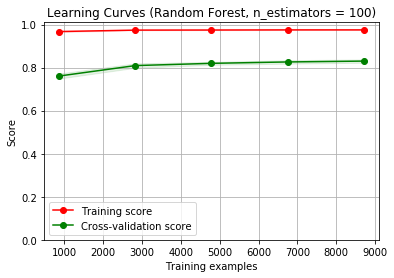

In [139]:
title = "Learning Curves (Random Forest, n_estimators = 100)"
# SVC is more expensive so we do a lower number of CV iterations:
# 这两条语句不能执行
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
cv=model_selection.ShuffleSplit(n_splits=10, test_size=0.2,random_state=0)#n_splits : K折验证的K值
#cv = model_selection.ShuffleSplit(len(df_train_data), n_iter=3, test_size=0.2, random_state=0)
estimator = RandomForestRegressor(n_estimators = 550)
plot_learning_curve(estimator, title, X, y, (0.0, 1.01), cv=cv, n_jobs=4)

plt.show()

## 2.8 模型打分

随着训练样本的增加，验证分数可以增加

训练集和验证测试集直接间隔那么大，这一定是过拟合了

In [140]:
print("随机森林回归/Random Forest(n_estimators=200, max_features=0.6, max_depth=15)")
for train, test in kf.split(df_train_data): 
    svc = RandomForestRegressor(n_estimators = 200, max_features=0.6, max_depth=15).fit(df_train_data[train], df_train_target[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        svc.score(df_train_data[train], df_train_target[train]), svc.score(df_train_data[test], df_train_target[test])))

随机森林回归/Random Forest(n_estimators=200, max_features=0.6, max_depth=15)
train score: 0.953, test score: -0.198

train score: 0.966, test score: 0.442

train score: 0.953, test score: 0.440

train score: 0.951, test score: 0.664

train score: 0.958, test score: 0.652



## 2.9 模型保存

scikit-learn已经有了模型持久化的操作，导入joblib即可

In [141]:
from sklearn.externals import joblib

In [142]:
joblib.dump(svc, "random_forest_train_model.pkl")

['random_forest_train_model.pkl']

# 3. 测试

In [143]:
df_test = pd.read_csv("test.csv",sep=",")

df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [144]:
df_test.shape

(6493, 9)

同理 处理test数据

In [145]:

df_test.head()
df_test['hour']=pd.DatetimeIndex(df_test.datetime).hour
df_test['day']=pd.DatetimeIndex(df_test.datetime).dayofweek
df_test['month']=pd.DatetimeIndex(df_test.datetime).month


df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 12 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
hour          6493 non-null int64
day           6493 non-null int64
month         6493 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 608.8+ KB


In [146]:
df_test_X = df_test.drop(['datetime'], axis = 1)
df_test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 11 columns):
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
hour          6493 non-null int64
day           6493 non-null int64
month         6493 non-null int64
dtypes: float64(3), int64(8)
memory usage: 558.1 KB


In [147]:

# ### 许多特征之间有太多相关性
# 
# #### season和month，二选一
# #### temp和atemp，二选一
# #### humidity和weather，windspeed，看rf的特征重要度


In [148]:
df_test_X.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month
season,1.000000,-0.075759,0.051488,-0.053554,0.401384,0.410626,0.083792,-0.154507,-0.005367,-0.002133,0.587553
holiday,-0.075759,1.000000,-0.255820,-0.033279,-0.071852,-0.072373,-0.031611,-0.003240,0.001860,-0.184079,0.046272
workingday,0.051488,-0.255820,1.000000,0.062447,0.096519,0.103202,0.059599,-0.053690,0.001438,-0.699302,-0.003701
weather,-0.053554,-0.033279,0.062447,1.000000,-0.179034,-0.185746,0.437406,0.057360,-0.016085,-0.044301,-0.005925
temp,0.401384,-0.071852,0.096519,-0.179034,1.000000,0.991936,-0.081734,-0.030990,0.125005,-0.032509,0.110559
atemp,0.410626,-0.072373,0.103202,-0.185746,0.991936,1.000000,-0.068666,-0.069655,0.123154,-0.036735,0.116878
humidity,0.083792,-0.031611,0.059599,0.437406,-0.081734,-0.068666,1.000000,-0.242708,-0.275278,-0.049784,0.096794
windspeed,-0.154507,-0.003240,-0.053690,0.057360,-0.030990,-0.069655,-0.242708,1.000000,0.121729,0.049981,-0.110585
hour,-0.005367,0.001860,0.001438,-0.016085,0.125005,0.123154,-0.275278,0.121729,1.000000,-0.002834,-0.004026
day,-0.002133,-0.184079,-0.699302,-0.044301,-0.032509,-0.036735,-0.049784,0.049981,-0.002834,1.000000,0.011971


加载模型

In [149]:
from sklearn.externals import joblib
 
clf = joblib.load("random_forest_train_model.pkl")


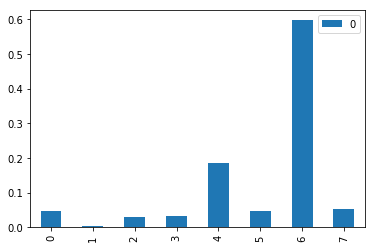

In [150]:
pd.DataFrame(clf.feature_importances_).plot(kind='bar')

In [151]:

y_pred = clf.predict(df_test_X)

ValueError: Number of features of the model must match the input. Model n_features is 8 and input n_features is 11 

In [ ]:
print(y_pred.shape)

In [ ]:
#对结果四舍五入
y_pred7 = [round(x) for x in y_pred]
df_test['count'] = y_pred7
df_test['count'] = df_test['count'].astype(int)
df_test.head()


In [ ]:
df_test.to_csv('result.csv', sep=',', columns=['datetime', 'count'], header=['datetime', 'count'], index = False)